In [1]:
# -*- coding: utf-8 -*-
import sys
import os
import numpy as np
import pandas as pd
import cobra
import matplotlib.pyplot as plt 
plt.rc('axes', axisbelow=True)

print('Python version:', sys.version)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('cobrapy version:', cobra.__version__)

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.18.3
pandas version: 1.0.3
cobrapy version: 0.15.4


In [2]:
def KORxn(model, rxns2KO):
    """Function for knocking out reactions."""
    for ID in rxns2KO:
        reaction = model.reactions.get_by_id(ID)
        reaction.knock_out()


In [3]:
def flux2file(model, product, psw, output_dir='tmp'):
    """Function of exporting flux data."""
    n = len(model.reactions)
    modelMatrix = np.empty([n, 9], dtype = object)
    for i in range(len(model.reactions)):
        x = model.reactions[i]
        modelMatrix[i, 0] = i + 1
        modelMatrix[i, 1] = x.id
        modelMatrix[i, 2] = x.name
        modelMatrix[i, 3] = x.reaction
        modelMatrix[i, 4] = x.subsystem
        modelMatrix[i, 5] = x.lower_bound
        modelMatrix[i, 6] = x.upper_bound
        modelMatrix[i, 7] = x.flux
        modelMatrix[i, 8] = abs(x.flux)
        
    df = pd.DataFrame(data = modelMatrix, 
                        columns = ['N', 'RxnID', 'RxnName', 'Reaction', 'SubSystem', 
                        'LowerBound', 'UpperBound', 'Flux-core', 'abs(Flux)'])
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    filepath = os.path.join(output_dir, '{}_{}.xlsx'.format(product, psw))
    df.to_excel(filepath, index=False)
    

## Summary of the changes in the model:

#### _E. coli_ core model with some changes:	

* Corrected the transhydrogenase (THD2) to one proton translocation;
* Deactivated pyruvate formate lyase (PFL) under aerobic coditions.

In [4]:
model = cobra.io.load_json_model(r'..\0_ecoli_models\e_coli_core.json')

model.reactions.THD2.subtract_metabolites({"h_e": -1, "h_c": 1})

In [5]:
KORxn_base = ['PFL']
KORxn(model, KORxn_base)

In [6]:
model.reactions.EX_glc__D_e.bounds = (0,0)

model_wt = model.copy()

### Firstly, model curations: 
knock out _lpd_ gene; anticipated results:  
* no growth on acetate only;  
* grow on acetate + formate (with formate dehydrogenase), and where formate serves only as electron source

In [7]:
# knock out lpdA
model.genes.b0116.knock_out()

In [8]:
# on acetate only
with model as m: 
    m.reactions.EX_ac_e.lower_bound = -10  # arbitrary 
    cobra.flux_analysis.pfba(m)
    m.summary()
    flux2file(m,'biomass_1','lpd_core')


IN FLUXES      OUT FLUXES    OBJECTIVES
-------------  ------------  ----------------------
o2_e   15      h2o_e  15.9   BIOMASS_Ecol...  0.115
ac_e   10      co2_e  15.1
h_e     7.69
nh4_e   0.627
pi_e    0.423


The model uses the oxidative pentose phosphate pathway generating NADPH, 
which is then used by NAD transhydrogenase (NADTRHD, sthA) transferring the electrons.  

Try to block it by KO GND.

In [9]:
with model_wt as m:
    m.reactions.EX_ac_e.lower_bound = -10  
    m.optimize()
    m.summary()
    
    print('\n','* - * - *')
    m.reactions.GND.knock_out()
    m.optimize()
    m.summary()

IN FLUXES      OUT FLUXES    OBJECTIVES
-------------  ------------  ----------------------
o2_e   12.4    h2o_e  13.9   BIOMASS_Ecol...  0.173
ac_e   10      co2_e  12.6
h_e     6.52
nh4_e   0.945
pi_e    0.638

 * - * - *
IN FLUXES      OUT FLUXES    OBJECTIVES
-------------  ------------  ----------------------
o2_e   12.4    h2o_e  13.9   BIOMASS_Ecol...  0.173
ac_e   10      co2_e  12.6
h_e     6.52
nh4_e   0.945
pi_e    0.638


In [10]:
# KO GND doesn't change the results on WT, so block it in the model.
with model as m: 
    m.reactions.EX_ac_e.lower_bound = -10
    KORxn(m, ['GND'])
    cobra.flux_analysis.pfba(m)
    m.summary()
    flux2file(m,'biomass_2','lpd_core')

Infeasible: None (infeasible)

In [11]:
# not growing on acetate now, try to add formate
# adding FDH reaction to the model
model_FDH = model.copy()
FDH = cobra.Reaction(id="FDH", name="formate dehydrogenase", lower_bound=0, upper_bound=1000) 
model_FDH.add_reaction(FDH)
FDH.add_metabolites({"for_c": -1, "nad_c": -1, "co2_c": 1, "nadh_c": 1})

with model_FDH as m: 
    m.reactions.EX_ac_e.lower_bound = -10
    m.reactions.EX_for_e.lower_bound = -100
    KORxn(m, ['GND'])
    cobra.flux_analysis.pfba(m)
    m.summary()
    flux2file(m,'biomass_for_1','lpd_core')
    print('\n','* - * - *')
    m.metabolites.for_c.summary()

IN FLUXES     OUT FLUXES    OBJECTIVES
------------  ------------  ----------------------
h_e    37.6   h2o_e  41.6   BIOMASS_Ecol...  0.391
for_e  35.4   co2_e  38.8
o2_e   20.6
ac_e   10
nh4_e   2.13
pi_e    1.44

 * - * - *
PRODUCING REACTIONS -- Formate (for_c)
--------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  --------------------------------
100%    35.4  FORt2     for_e + h_e --> for_c + h_c

CONSUMING REACTIONS -- Formate (for_c)
--------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  --------------------------------
100%    35.4  FDH       for_c + nad_c --> co2_c + nadh_c


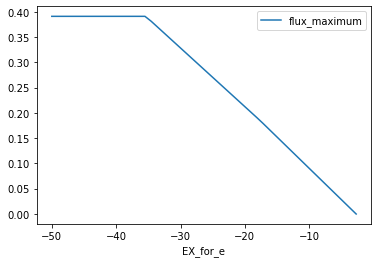

In [12]:
# Worked.
# And formate was not all used. 
with model_FDH as m: 
    m.reactions.EX_ac_e.lower_bound = -10
    m.reactions.EX_for_e.lower_bound = -50
    KORxn(m, ['GND'])
    prod_env = cobra.flux_analysis.production_envelope(m, ['EX_for_e'], carbon_sources='EX_ac_e',points=50)
    prod_env.plot(kind='line',x='EX_for_e',y='flux_maximum')

The `model` now cannot use acetate as a sole carbon source.  
Formate (with FDH) can be used as electron source. And it serves only as electron donor. 

### Futher validations: 
From Fig. 4A, WT grown on aceate has doubling time **2.9 h**, i.e., **0.24 h<sup>-1</sup>**.

In [13]:
DT = 2.9   # WT grow on 20 mM acetate -> DT = 2.9 h
gr = np.log(2) / DT  
print('growth rate is %.2f / hr' % gr)

growth rate is 0.24 / hr


In [14]:
with model_wt as m:
    m.reactions.BIOMASS_Ecoli_core_w_GAM.bounds = (gr, gr)
    m.reactions.EX_glc__D_e.bounds = (0,0)
    m.reactions.EX_ac_e.bounds = (-1000,0)
    m.objective = 'EX_ac_e'
    m.objective_direction = 'max'
    m.optimize()
    m.summary()

IN FLUXES      OUT FLUXES    OBJECTIVES
-------------  ------------  ------------
o2_e   15.6    h2o_e  17.7   EX_ac_e  -13
ac_e   13      co2_e  15.9
h_e     8.25
nh4_e   1.3
pi_e    0.879


In [15]:
# modeling Fig. 2, glucose + acetate
with model as m:
    m.reactions.EX_glc__D_e.lower_bound = -10.5
    m.reactions.EX_ac_e.lower_bound = -13
    KORxn(m,['GND'])
    cobra.flux_analysis.pfba(m)
    m.summary()

    sol = m.objective.value   # 1/hour

print('\n', 'The doubling time is %.2f hr' % (np.log(2) / sol))

IN FLUXES        OUT FLUXES    OBJECTIVES
---------------  ------------  ----------------------
o2_e      15     h2o_e  29.7   BIOMASS_Ecol...  0.445
ac_e      13     pyr_e  21.8
glc__D_e  10.5   h_e    17.7
nh4_e      2.43  co2_e   4.63
pi_e       1.64

 The doubling time is 1.56 hr


The maximum acetate uptake rate is **13.0 mmol/gCDW/h**, which is within the range of 11 - 15.5, reported in https://doi.org/10.1038/84379.   

Also, on glc + Ac, the doubling time is colse to the experiment value *1.6 h* (Fig. 2). Here the glc uptake rate is set to 10.5 according to [Varma & Palsson, 1994](https://pubmed.ncbi.nlm.nih.gov/7986045/).

Therefore, the model is good: _lpd_ (b0116, affecting PDH & AKGDH), GND and PFL are knocked out.

Above, the input to the model is substrate uptake rate in _mmol/gCDW/h_, and the output is growth rate, _h<sup>-1</sup>_. If the input is concentration in _mM_ (i.e., _mmol/L_), then the output will be yield in _gCDW/L_:  
$$\dfrac{mmol/gCDW/h}{1/h} * \dfrac{(gCDW/h)/L}{(gCDW/h)/L} = \dfrac{mmol/L}{gCDW/L}$$

Using BionNumber [109836](https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=4&id=109836)), one unit of OD600 _E. coli_ corresponds to a cell dry weight of _0.39 gCDW/L_, biomass yield can be converted to OD600 (increase).  


**Assuming all the limiting substrates are consumed in the experiments** 
### In the case of on acetate + formate (Fig. 4B):

In [16]:
KORxn(model, ['GND'])
KORxn(model_FDH,['GND'])

with model_FDH as m:
    m.reactions.EX_ac_e.lower_bound = -20   # in mM
    m.reactions.EX_for_e.lower_bound = -1000  # no limiting
    cobra.flux_analysis.pfba(m)
    m.summary()
    flux2file(m,'biomass_for_2','lpd_core')
    print('\n', '* - * - *')
    print('OD increase: %.2f' % (m.objective.value / 0.39))
    
    print('\n', '* - * - *')
    m.metabolites.for_c.summary()

    print('\n', '* - * - *')
    m.metabolites.nadh_c.summary()

IN FLUXES     OUT FLUXES    OBJECTIVES
------------  ------------  ----------------------
h_e    68.4   h2o_e  76.5   BIOMASS_Ecol...  0.782
for_e  64.1   co2_e  70.8
o2_e   37.9
ac_e   20
nh4_e   4.26
pi_e    2.88

 * - * - *
OD increase: 2.01

 * - * - *
PRODUCING REACTIONS -- Formate (for_c)
--------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  --------------------------------
100%    64.1  FORt2     for_e + h_e --> for_c + h_c

CONSUMING REACTIONS -- Formate (for_c)
--------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  --------------------------------
100%    64.1  FDH       for_c + nad_c --> co2_c + nadh_c

 * - * - *
PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide - reduced (nadh_c)
---------------------------------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
79%   64.1   FDH       

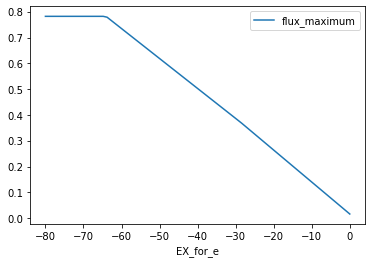

In [17]:
with model_FDH as m: 
    m.reactions.EX_ac_e.lower_bound = -20  # in mM
    m.reactions.EX_for_e.lower_bound = -80  # in mM
    prod_env_for = cobra.flux_analysis.production_envelope(m, ['EX_for_e'], carbon_sources='EX_ac_e',points=80)
    prod_env_for.plot(kind='line',x='EX_for_e',y='flux_maximum') 
    # flux_maximum -> biomass yield

For the $\Delta$_lpd_ strain grows on 20 mM acetate and formate:  
* formate exchange or FDH reaction needs to be **64.1 mM** to generate energy, in order to have maximum yield, **0.782 gCDW/L** that is OD600 (increase) 2. 
* In such acetate limiting conditions: part of the electrons comes also from acetate, **79%** comes from directly from formate.  
* **84%** electrons are used to generate ATP.  
    
    
**However, in Fig. 4B, maximum ODs are all far below 2, and even below below the WT on acetate alone. The maximum ODs increased along with the increase of formate concentration. These indicates that acetate is not the limit but formate (energy source). For the $\Delta$_lpd_ strain on acetate and formate, formate is the major energy source, acetate serves mainly as carbon source, the strain should have higher biomass yield than WT on soly acetate, where acetate is both carbon and energy sources.**  

Experimentally confirmation of acetate is not limiting: use higher acetate do the same growth as Fig. 4B.  

Also, the growth rates of the $\Delta$_lpd_ strain on acetate and formate are lower than WT on acetate. Especially when formate concentration below 13 mM, the growth rate increased along with the formate concentration increase, this could indicate that formate uptake rate is the limit under low concentrations.  

In [18]:
with model_FDH as m: 
    gr = np.log(2) / 4.9  # 20 mM ac + 44 mM formate, the highest growth rate
    m.reactions.EX_ac_e.lower_bound = -13
    m.reactions.BIOMASS_Ecoli_core_w_GAM.bounds = (gr, gr)
    m.reactions.EX_for_e.lower_bound = -1000
    m.objective = 'EX_for_e'
    m.objective_direction = 'max'
    cobra.flux_analysis.pfba(m)
    m.summary()
    # flux2file(model,'biomass_for_3','lpd_core')

    print('\n', '* - * - *')
    m.metabolites.for_c.summary()

    print('\n', '* - * - *')
    m.metabolites.nadh_c.summary()

IN FLUXES      OUT FLUXES    OBJECTIVES
-------------  ------------  ---------------
h_e    18.4    h2o_e  24.6   EX_for_e  -12.9
o2_e   14.6    co2_e  18.8
ac_e   13      pyr_e   4.69
for_e  12.9
nh4_e   0.771
pi_e    0.52

 * - * - *
PRODUCING REACTIONS -- Formate (for_c)
--------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  --------------------------------
100%    12.9  FORt2     for_e + h_e --> for_c + h_c

CONSUMING REACTIONS -- Formate (for_c)
--------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  --------------------------------
100%    12.9  FDH       for_c + nad_c --> co2_c + nadh_c

 * - * - *
PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide - reduced (nadh_c)
---------------------------------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
55%  12.9    FDH         for_c + nad_c --> c

Assuming the acetate uptake rate to be the maximum as WT on acetate alone, _13 mmol/gCDW/h_, the maximum formate uptake (or FDH) is calculated to be **12.9 mmol/gCDW/h**.  

* In this case: **55%** comes from directly from formate, acetate contributes **45%** by secreting pyruvate.  
* **98%** electrons are used to generate ATP.    


In [19]:
growth_for = pd.DataFrame({
    'formate_conc': np.logspace(0,10,11,base=1/1.5)*100,
    'doubling_time': np.array([5.9,5.3,4.9,5.0,5.3,5,6.1,9.1,11,28,36]),
    'max_OD600': np.array([0.43,0.363,0.273,0.211,0.163,0.122,0.098,0.080,0.057,0.031,0.023])
})

growth_for['growth_rate'] = np.log(2) / growth_for['doubling_time']
growth_for

,formate_conc,doubling_time,max_OD600,growth_rate
0,100.000000,5.9,0.430,0.117483
1,66.666667,5.3,0.363,0.130782
2,44.444444,4.9,0.273,0.141459
3,29.629630,5.0,0.211,0.138629
4,19.753086,5.3,0.163,0.130782
5,13.168724,5.0,0.122,0.138629
6,8.779150,6.1,0.098,0.113631
7,5.852766,9.1,0.080,0.076170
8,3.901844,11.0,0.057,0.063013
9,2.601229,28.0,0.031,0.024755


Since formate (uptake or oxidation) is the limit for growth, it determines the biomass yields. Assuming formate is fully consumed:

In [20]:
with model_FDH as m: 
    m.reactions.EX_ac_e.lower_bound = -20  # in mM
    for i in range(len(growth_for['growth_rate'])):
        m.reactions.EX_for_e.lower_bound = -growth_for.loc[i,'formate_conc']
        cobra.flux_analysis.pfba(m)
        growth_for.loc[i, 'BioYield'] = m.reactions.BIOMASS_Ecoli_core_w_GAM.flux  # in gCDW/L
        growth_for.loc[i, 'OD600_cal'] = growth_for.loc[i, 'BioYield'] / 0.39 # convert to OD
                
growth_for

,formate_conc,doubling_time,max_OD600,growth_rate,BioYield,OD600_cal
0,100.000000,5.9,0.430,0.117483,0.782157,2.005532
1,66.666667,5.3,0.363,0.130782,0.782157,2.005532
2,44.444444,4.9,0.273,0.141459,0.554160,1.420923
3,29.629630,5.0,0.211,0.138629,0.382164,0.979908
4,19.753086,5.3,0.163,0.130782,0.260683,0.668419
5,13.168724,5.0,0.122,0.138629,0.179108,0.459251
6,8.779150,6.1,0.098,0.113631,0.124724,0.319806
7,5.852766,9.1,0.080,0.076170,0.088469,0.226843
8,3.901844,11.0,0.057,0.063013,0.064298,0.164867
9,2.601229,28.0,0.031,0.024755,0.048185,0.123550


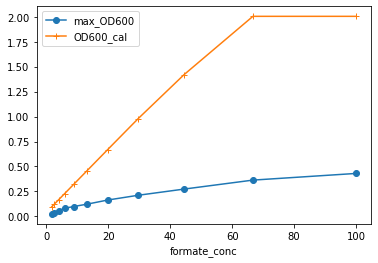

In [21]:
# clearly, when formate above 44 mM, it is not fully consumed. Even becoming 'toxic'.
growth_for.plot(x='formate_conc', y=['max_OD600', 'OD600_cal'], style=['o-', '+-'])

### In the Ethanol, Fig. 3
50 mM EtOH condition: doubling time is 2.5 h, max OD600 is 1.48

In [22]:
with model as m: 
    gr = np.log(2) / 2.5
    m.reactions.EX_etoh_e.lower_bound = -1000
    m.reactions.BIOMASS_Ecoli_core_w_GAM.bounds = (gr, gr)
    m.objective = 'EX_etoh_e'
    m.objective_direction = 'max'
    m.optimize()
    m.summary()
    flux2file(m,'biomass_etoh','lpd_core')

IN FLUXES      OUT FLUXES    OBJECTIVES
-------------  ------------  ----------------
o2_e    14     h2o_e  17     EX_etoh_e  -9.87
etoh_e   9.87  h_e     6.95
nh4_e    1.51  co2_e   3.77
pi_e     1.02  pyr_e   1.39


The maximum uptake rate of ethanol is calculated to be **9.87 mmol/gCDW/h**.  
There is pyruvate secretion.  

Then, if assuming all EtOH is consumed and yields biomass, *50 mM* EtOH will be converted into biomass:  

In [23]:
with model as m:
    m.reactions.EX_etoh_e.lower_bound = -50
    cobra.flux_analysis.pfba(m)
    m.summary()

    print('\n', '* - * - *')
    Y = model.objective.value
    print('Biomass yield is %.2f gCDW/L' % Y)
    OD = Y / 0.39 
    print('Which corresponding to OD %.2f' % OD)

IN FLUXES      OUT FLUXES    OBJECTIVES
-------------  ------------  ---------------------
o2_e    67.3   h2o_e  83.3   BIOMASS_Ecol...  1.72
etoh_e  50     h_e    37.5
nh4_e    9.39  co2_e  17.8
pi_e     6.33  pyr_e   2.99

 * - * - *
Biomass yield is 1.72 gCDW/L
Which corresponding to OD 4.41


### In the case of MeOH as energy source, Fig. 5B


In [24]:
# building the model
model_MDH = model.copy()

meoh_c = cobra.Metabolite(id='meoh_c',
                          formula='CH4O',
                          name='methanol',
                          compartment='c')
fald_c = cobra.Metabolite(id='fald_c',
                          formula='CH2O',
                          name='Formaldehyde',
                          compartment='c')

EX_meoh_e = cobra.Reaction(id="EX_meoh_e", name="methanol exchange", lower_bound=0, upper_bound=1000) 
model_MDH.add_reaction(EX_meoh_e)
EX_meoh_e.add_metabolites({meoh_c: -1})

MeDH = cobra.Reaction(id="MeDH", name="methanol dehydrogenase", lower_bound=0, upper_bound=1000) 
model_MDH.add_reaction(MeDH)
MeDH.add_metabolites({meoh_c: -1, "nad_c": -1, fald_c: 1, "nadh_c": 1, 'h_c': 1})

FRM = cobra.Reaction(id="FRM", name="formaldehyde oxidation, overall", lower_bound=0, upper_bound=1000) 
model_MDH.add_reaction(FRM)
FRM.add_metabolites({fald_c: -1, "nad_c": -1, 'h2o_c': -1, "for_c": 1, "nadh_c": 1, 'h_c': 2})

In [25]:
# from Fig. 5A
with model_wt as m:
    gr = np.log(2)/3.4  # WT, the maximum growth rate on 20 mM acetate + 600 mM MeOH
    m.reactions.BIOMASS_Ecoli_core_w_GAM.bounds = (gr, gr)
    m.reactions.EX_glc__D_e.bounds = (0,0)
    m.reactions.EX_ac_e.bounds = (-1000,0)
    m.objective = 'EX_ac_e'
    m.objective_direction = 'max'
    m.optimize()
    m.summary()
    print('The maximum acetate uptake rate is %.2f' %(- m.objective.value))

IN FLUXES     OUT FLUXES    OBJECTIVES
------------  ------------  --------------
o2_e   13.9   h2o_e  15.6   EX_ac_e  -11.4
ac_e   11.4   co2_e  14.2
h_e     7.32
nh4_e   1.11
pi_e    0.75
The maximum acetate uptake rate is 11.41


In [26]:
with model_MDH as m: 
    gr = np.log(2) / 5.3  # 20 mM ac + 667 mM MeOH, the highest growth rate
    m.reactions.EX_ac_e.lower_bound = -11.4
    m.reactions.BIOMASS_Ecoli_core_w_GAM.bounds = (gr, gr)
    m.reactions.EX_meoh_e.lower_bound = -1000
    m.objective = 'EX_meoh_e'
    m.objective_direction = 'max'
    cobra.flux_analysis.pfba(m)
    m.summary()
    flux2file(m,'biomass_meoh_1','lpd_core')

    print('\n', '* - * - *')
    m.metabolites.for_c.summary()

    print('\n', '* - * - *')
    m.metabolites.nadh_c.summary()

IN FLUXES      OUT FLUXES    OBJECTIVES
-------------  ------------  ----------------
o2_e   14.1    h2o_e  17.2   EX_meoh_e  -7.06
ac_e   11.4    for_e   7.06
nh4_e   0.713  co2_e   5.15
pi_e    0.481  pyr_e   4.03
               h_e     2.31

 * - * - *
PRODUCING REACTIONS -- Formate (for_c)
--------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  -------------------------------------------------
100%    7.06  FRM       fald_c + h2o_c + nad_c --> for_c + 2 h_c + nadh_c

CONSUMING REACTIONS -- Formate (for_c)
--------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  -------------------------------------------------
100%    7.06  FORt      for_e <-- for_c

 * - * - *
PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide - reduced (nadh_c)
---------------------------------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  ------------------------------------

Assuming the acetate uptake rate to be the maximum as WT on acetate + MeOH, _11.4 mmol/gCDW/h_, the maximum MeOH uptake is calculated to be **7.06 mmol/gCDW/h**. Similar to the formate:  

* **62%** (MeDH + FRM) comes from directly from methanol, acetate contributes **38%** by secreting pyruvate.  
* **98%** electrons are used to generate ATP.   

In [27]:
growth_meoh = pd.DataFrame({
    'MeOH_conc': np.logspace(0,9,10,base=1/1.5)*1000,
    'doubling_time': np.array([11,5.3,8.9,11,12,12,12,12,14,18]),
    'max_OD600': np.array([0.278,0.504,0.341,0.234,0.133,0.075,0.062,0.047,0.044,0.034])
})

growth_meoh['growth_rate'] = np.log(2) / growth_meoh['doubling_time']

with model_MDH as m:     
    m.reactions.EX_ac_e.lower_bound = -20  # in mM
    for i in range(len(growth_meoh['growth_rate'])):
        m.reactions.EX_meoh_e.lower_bound = -growth_meoh.loc[i,'MeOH_conc']
        cobra.flux_analysis.pfba(m)
        growth_meoh.loc[i, 'BioYield'] = m.reactions.BIOMASS_Ecoli_core_w_GAM.flux  # in gCDW/L
        growth_meoh.loc[i, 'OD600_cal'] = growth_meoh.loc[i, 'BioYield'] / 0.39 # convert to OD
                
growth_meoh

,MeOH_conc,doubling_time,max_OD600,growth_rate,BioYield,OD600_cal
0,1000.000000,11.0,0.278,0.063013,0.782157,2.005532
1,666.666667,5.3,0.504,0.130782,0.782157,2.005532
2,444.444444,8.9,0.341,0.077882,0.782157,2.005532
3,296.296296,11.0,0.234,0.063013,0.782157,2.005532
4,197.530864,12.0,0.133,0.057762,0.782157,2.005532
5,131.687243,12.0,0.075,0.057762,0.782157,2.005532
6,87.791495,12.0,0.062,0.057762,0.782157,2.005532
7,58.527663,12.0,0.047,0.057762,0.782157,2.005532
8,39.018442,14.0,0.044,0.049511,0.782157,2.005532
9,26.012295,18.0,0.034,0.038508,0.581764,1.491703


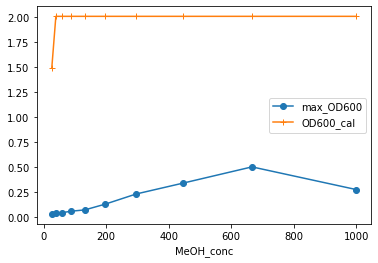

In [28]:
# all the yields are below the calculated ones, the concentrations of MeOH doesn't reflect its oxidation
growth_meoh.plot(x='MeOH_conc', y=['max_OD600', 'OD600_cal'], style=['o-', '+-'])

### Fig. 6

In [29]:
growth_MDH = pd.DataFrame({
    'MDH':['CnMDH', 'BmMDH*','BsMDH','CgMDH'],
    'doubling_time': [2.7,3.2,3.8,10.1]
})
growth_MDH['growth_rate'] = np.log(2) / growth_MDH['doubling_time']
growth_MDH

,MDH,doubling_time,growth_rate
0,CnMDH,2.7,0.256721
1,BmMDH*,3.2,0.216608
2,BsMDH,3.8,0.182407
3,CgMDH,10.1,0.068628


In [30]:
# first build the model
model_C1 = model_wt.copy()
full_model = cobra.io.load_json_model(r'..\0_ecoli_models\iML1515.json')

newRxns = [
    model_MDH.reactions.EX_meoh_e,
    model_MDH.reactions.MeDH,
    model_MDH.reactions.FRM,
    full_model.reactions.FTHFLi,  # formate-THF ligase
    full_model.reactions.MTHFC,   # Methenyltetrahydrofolate cyclohydrolase
    full_model.reactions.MTHFD,   # Methylenetetrahydrofolate dehydrogenase (NADP)
    full_model.reactions.GLYCL,   # GCV
    full_model.reactions.GHMT2r   # GlyA
]

# to check the reactions
for i in newRxns:
    print(i)

EX_meoh_e: meoh_c --> 
MeDH: meoh_c + nad_c --> fald_c + h_c + nadh_c
FRM: fald_c + h2o_c + nad_c --> for_c + 2 h_c + nadh_c
FTHFLi: atp_c + for_c + thf_c --> 10fthf_c + adp_c + pi_c
MTHFC: h2o_c + methf_c <=> 10fthf_c + h_c
MTHFD: mlthf_c + nadp_c <=> methf_c + nadph_c
GLYCL: gly_c + nad_c + thf_c --> co2_c + mlthf_c + nadh_c + nh4_c
GHMT2r: ser__L_c + thf_c <=> gly_c + h2o_c + mlthf_c


In [31]:
newRxns[6].bounds = (-1000,1000)  # change GCV to be reversible
model_C1.add_reactions(newRxns)   # add the new reactions to the model

# update the biomass function by replacing 3pg to ser, gly and C1
# from DOI 10.1021/acssynbio.8b00093
model_C1.reactions.BIOMASS_Ecoli_core_w_GAM.build_reaction_from_string("0.462 ser__L_c + 1.033 gly_c + 1.033 mlthf_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 3.4454 glu__L_c + 59.35 h2o_c + 2.051 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c -> 59.81 adp_c + 2.6222 akg_c + 3.7478 coa_c + 58.27 h_c + 2.051 nadh_c + 13.0279 nadp_c + 58.31 pi_c + 1.033 thf_c")
print(model_C1.reactions.BIOMASS_Ecoli_core_w_GAM)

BIOMASS_Ecoli_core_w_GAM: 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 3.4454 glu__L_c + 1.033 gly_c + 59.35 h2o_c + 1.033 mlthf_c + 2.051 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c + 0.462 ser__L_c --> 59.81 adp_c + 2.6222 akg_c + 3.7478 coa_c + 58.27 h_c + 2.051 nadh_c + 13.0279 nadp_c + 58.31 pi_c + 1.033 thf_c


In [32]:
# assuming glc uptake rate is -10.5 as WT
with model_C1 as m:
    m.reactions.EX_glc__D_e.lower_bound = -10.5
    m.reactions.EX_meoh_e.lower_bound = -1000
    m.objective = 'MeDH'
    m.objective_direction = 'min'
    for i in range(len(growth_MDH)):
        gr = growth_MDH.loc[i,'growth_rate']
        m.reactions.BIOMASS_Ecoli_core_w_GAM.bounds = (gr, gr)
        # m.optimize()
        cobra.flux_analysis.pfba(m)
        growth_MDH.loc[i,'MeDH_flux'] = m.reactions.MeDH.flux  # in mmol/gCDW/h

growth_MDH

,MDH,doubling_time,growth_rate,MeDH_flux
0,CnMDH,2.7,0.256721,0.767596
1,BmMDH*,3.2,0.216608,0.647659
2,BsMDH,3.8,0.182407,0.545397
3,CgMDH,10.1,0.068628,0.205199


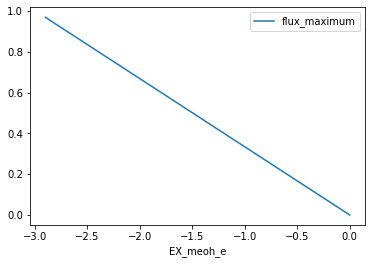

In [33]:
with model_C1 as m: 
    m.reactions.EX_glc__D_e.lower_bound = -10.5
    m.reactions.EX_meoh_e.lower_bound = -50
    m.reactions.EX_for_e.knock_out()
    prod_env_MDH = cobra.flux_analysis.production_envelope(m, ['EX_meoh_e'], carbon_sources='EX_glc__D_e',points=50)
    prod_env_MDH.plot(kind='line',x='EX_meoh_e',y='flux_maximum')

In [34]:
with model_C1 as m: 
    m.reactions.EX_glc__D_e.lower_bound = -10.5
    m.reactions.EX_meoh_e.lower_bound = -50
    m.reactions.EX_for_e.knock_out()
    m.optimize()
    m.summary()
    print('maximum methanol exchange flux is %.2f mmol/gCDW/h' % m.reactions.EX_meoh_e.flux)

IN FLUXES        OUT FLUXES    OBJECTIVES
---------------  ------------  ---------------------
o2_e      25     h2o_e  34.6   BIOMASS_Ecol...  0.97
glc__D_e  10.5   co2_e  24.6
nh4_e      5.29  h_e    19.4
pi_e       3.57
maximum methanol exchange flux is -2.90 mmol/gCDW/h
